In [1]:
import pandas as pd
import numpy as np
import cooler
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Patch
import scipy.io


from sklearn.decomposition import PCA
from scipy import stats
import networkx as nx
from sklearn.metrics import jaccard_score

import os
import sys
from importlib import reload

import filters
import pore_c_utils as pcu
import binning_utils as binning
import plotting as hicPlot

In [2]:
reload(pcu)

<module 'pore_c_utils' from '/home/cstansbu/git_repositories/scPoreC-analysis/notebooks/pore_c_utils.py'>

# Functions

In [3]:
def getPC1(A):
    """A function to get the first component"""
    pca = PCA(n_components=1, svd_solver='full')
    pca.fit(A)
    return pca.components_[0, :]


def getCorrelationMatrix(A):
    """A function to generate a column-wise correlation matrix
    as described by Lieberman-Aiden 2009 """
    
    C = np.zeros(A.shape)
    n = A.shape[0]
    
    for i in range(n):
        for j in range(n):
        
            r = stats.pearsonr(A[:, i], A[:, j])[0]

            C[i, j] = r
            C[j, i] = r
    C = np.where(np.isnan(C), 0, C)
    
    return C


def getJaccardMatrix(A):
    """A function to generate a column-wise Jaccard matrix """
    C = np.zeros(A.shape)
    n = A.shape[0]
    
    for i in range(n):
        for j in range(n):
        
            r = jaccard_score(A[:, i], A[:, j])

            C[i, j] = r
            C[j, i] = r
    C = np.where(np.isnan(C), 0, C)
    
    return C
        

def pageRankNormalize(A, d=0.85):
    N = A.shape[1]
    A_hat = (d * A + (1 - d) / N)
    return A_hat

In [4]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")

chromDict = dict(zip(assembly['RefSeq accession'],assembly['Chromosome'].apply(lambda x : f"chr{x}")))

# the reverse for easy lookup
chromDict_r = {v: k for k, v in chromDict.items()}

chromOrder = list(chromDict.values())
chromOrder

['chr1',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chrX',
 'chrY']

In [5]:
reload(pcu)

# load pore c data 
scPorecFilepath = "/nfs/turbo/umms-indikar/shared/tools/Pore-C-Snakemake/results_ES5to12/matrix/"

cellNums = [1, 2, 4, 5, 6, 7] # dropping cell 3 due to sparsity
filetags = [f"run0{x}" for x in cellNums]

porec = {}

for cell in filetags:
    fullPath = f"{scPorecFilepath}NlaIII_{cell}_GRCm39_unphased.matrix.mcool"
    
    A, porecChromInfo, porecIndex = pcu.loadPorecCooler(fullPath, assembly, chromOrder)    
    
    # reindex
    porecMat = A[porecIndex, :][:, porecIndex]
    
    print(f"{cell=} {porecMat.shape=}")
    
    porec[cell] = porecMat
    
porec.keys()

cell='run01' porecMat.shape=(2734, 2734)
cell='run02' porecMat.shape=(2734, 2734)
cell='run04' porecMat.shape=(2734, 2734)
cell='run05' porecMat.shape=(2734, 2734)
cell='run06' porecMat.shape=(2734, 2734)
cell='run07' porecMat.shape=(2734, 2734)


dict_keys(['run01', 'run02', 'run04', 'run05', 'run06', 'run07'])

In [6]:
scHICfilepath = f"/nfs/turbo/umms-indikar/shared/projects/poreC/nagano_2017_data/nagano_1MB_raw_BALANCED.scool"
cellList = list(cooler.fileops.list_coolers(scHICfilepath))
print(f"{len(cellList)=}")

len(cellList)=3882


In [7]:
sampleSize = len(porec) # sample 6 randomly
sample = np.random.choice(cellList, sampleSize, replace=False)

hic = {}

for s in sample:
    filetag = "_".join(s.split("_")[0:2]).replace("/", "")    
    A, hicChromInfo, hicIndex = pcu.loadNagano2017SingleCell(scHICfilepath, s, chromOrder, balance=False)
    
    # reindex the matrix
    hicMat = A[hicIndex, :][:, hicIndex]
    print(f"{filetag=} {hicMat.shape=}")
    
    hic[filetag] = hicMat

hic.keys()

filetag='Diploid_9' hicMat.shape=(2665, 2665)
filetag='Diploid_29' hicMat.shape=(2665, 2665)
filetag='Diploid_26' hicMat.shape=(2665, 2665)
filetag='Diploid_5' hicMat.shape=(2665, 2665)
filetag='Diploid_19' hicMat.shape=(2665, 2665)
filetag='Diploid_10' hicMat.shape=(2665, 2665)


dict_keys(['Diploid_9', 'Diploid_29', 'Diploid_26', 'Diploid_5', 'Diploid_19', 'Diploid_10'])

In [8]:
# break

In [64]:
# hicChromInfo
# porecChromInfo

,region,start,end,length,chromName
0,NC_000067.7,0,196,196,chr1
1,NC_000068.8,202,384,182,chr2
2,NC_000069.7,384,544,160,chr3
3,NC_000070.7,544,701,157,chr4
4,NC_000071.7,702,854,152,chr5
5,NC_000072.7,859,1009,150,chr6
6,NC_000073.7,1009,1154,145,chr7
7,NC_000074.7,1155,1286,131,chr8
8,NC_000075.7,1286,1411,125,chr9
9,NC_000076.7,1411,1542,131,chr10


In [10]:
def binarize(A):
    return np.where(A > 0, 1, 0)

pore-c
sumContacts=690041
sumDiag=2603
sumUpper=687438
diagUpperRatio=0.004

hi-c
sumContacts=84730
sumDiag=2570
sumUpper=82160
diagUpperRatio=0.031


<ipython-input-66-8504cc065535>:62: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax1.set_xticks([], [])
<ipython-input-66-8504cc065535>:84: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax2.set_xticks([], [])


(2630.0, 0.0)

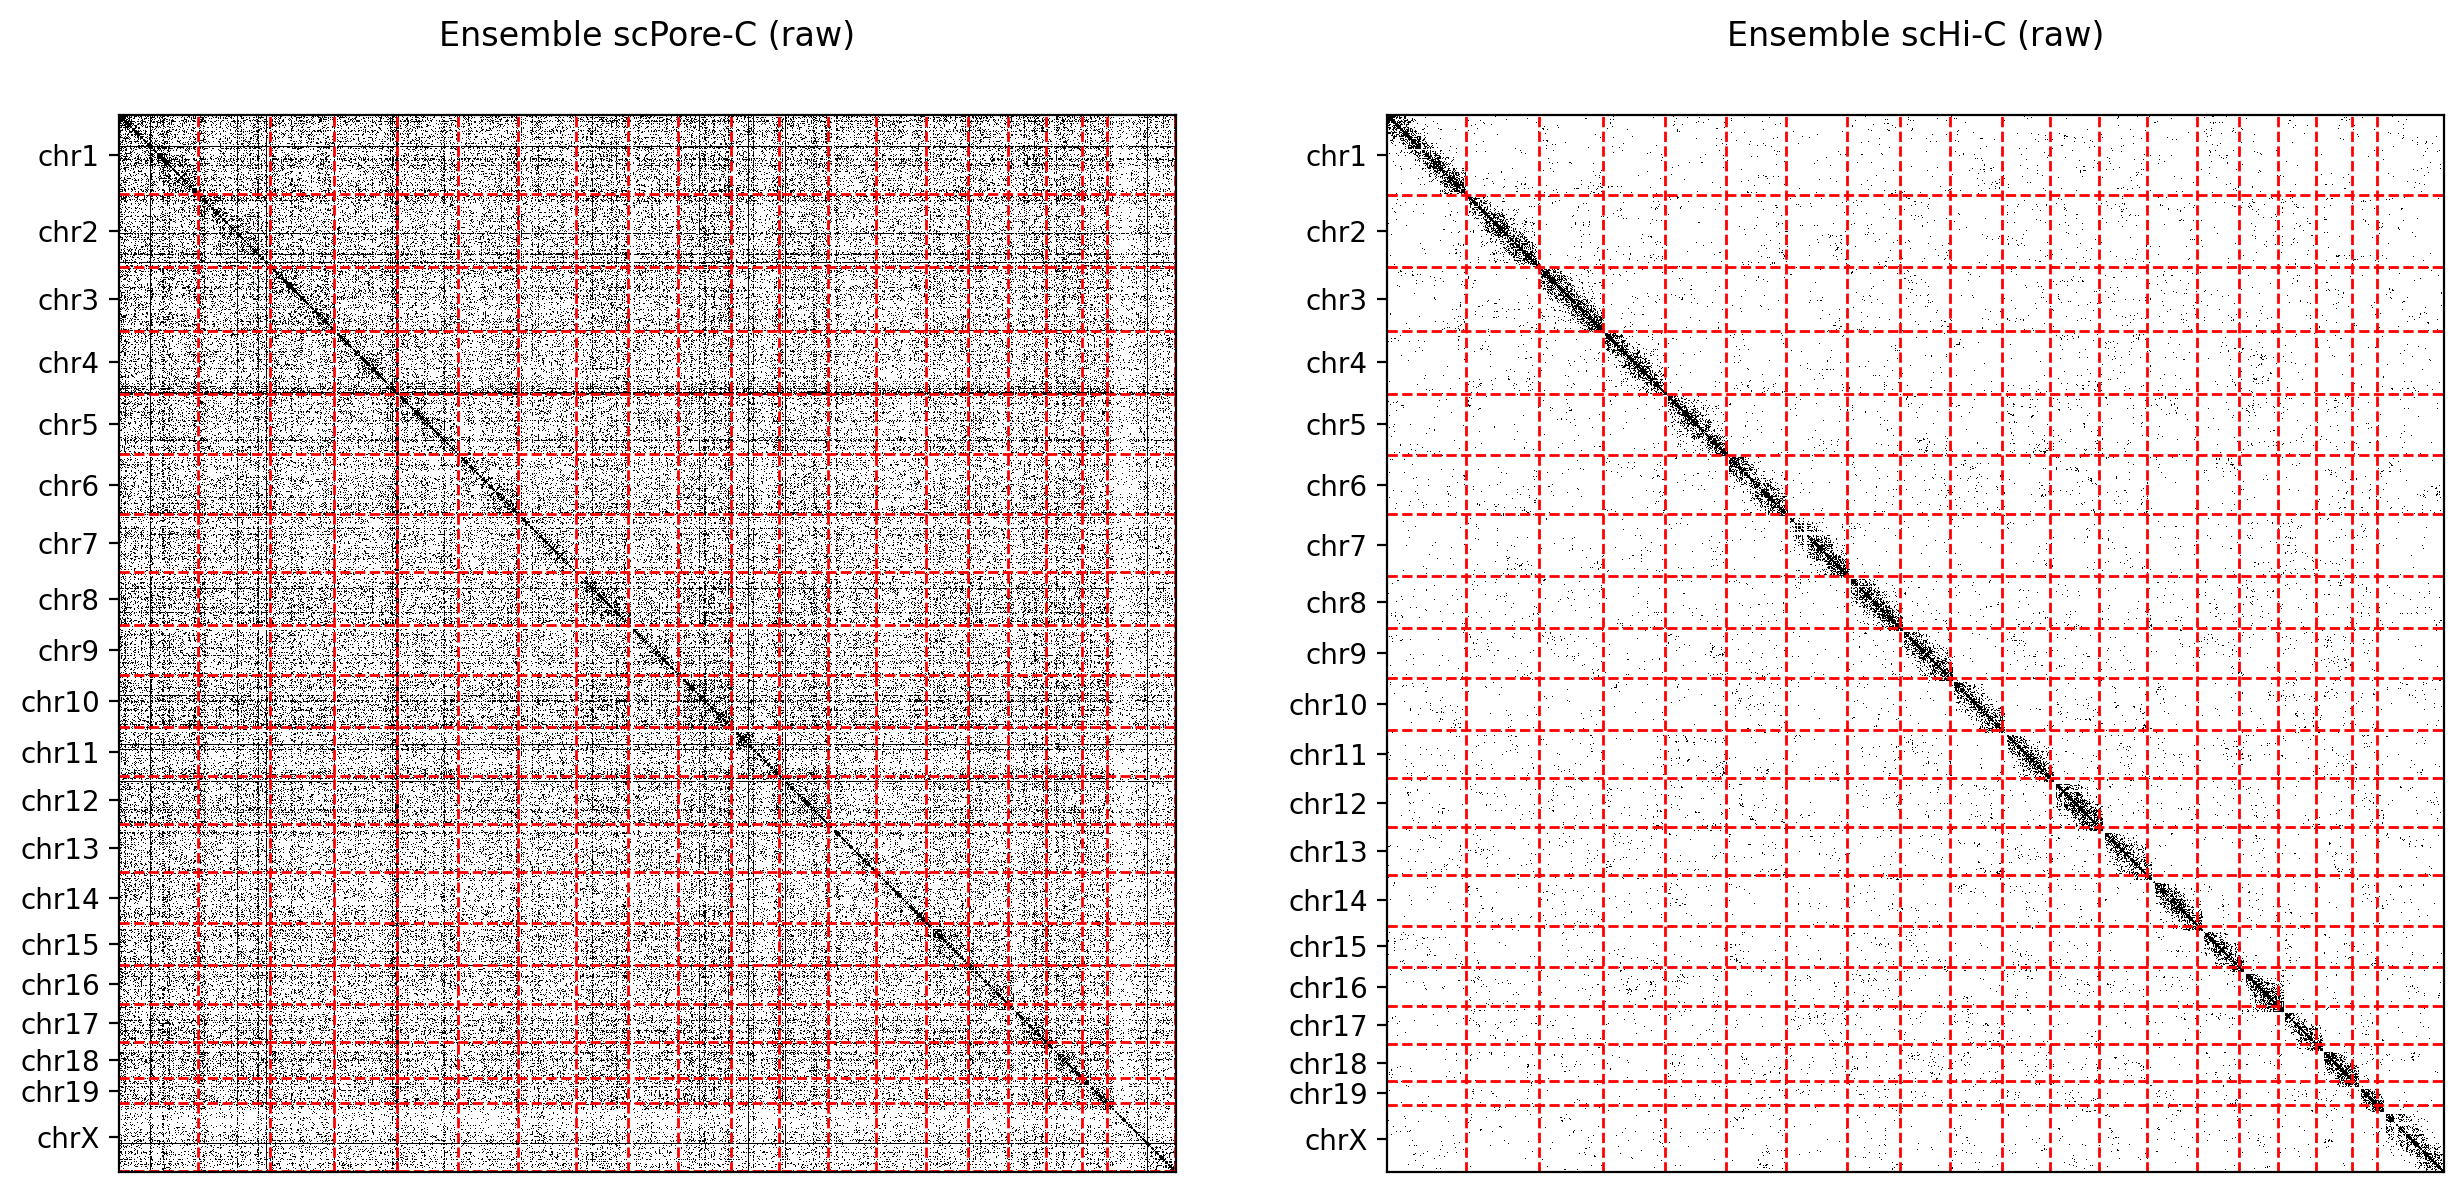

In [66]:
# pseduobulk summaries

def getStats(A):
    sumContacts = np.triu(A).sum()
    sumDiag = np.diag(A).sum()
    sumUpper = np.triu(A).sum() - sumDiag
    diagUpperRatio = sumDiag / sumUpper
    
    print(f"{sumContacts=}")
    print(f"{sumDiag=}")
    print(f"{sumUpper=}")
    print(f"{diagUpperRatio=:.3f}")

bulkPoreC = np.zeros(porecMat.shape)
for runId, A in porec.items():
    bulkPoreC += A
    
bulkP = binarize(bulkPoreC)
print("pore-c")
getStats(bulkP)
    
bulkhiC = np.zeros(hicMat.shape)
for runId, A in hic.items():
    bulkhiC += A
    
bulkH = binarize(bulkhiC)
print("\nhi-c")
getStats(bulkH)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 15, 15
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.matshow(bulkP, cmap='binary')
ax1.set_title('Ensemble scPore-C (raw)')

ax2.matshow(bulkH, cmap='binary')
ax2.set_title('Ensemble scHi-C (raw)')

ytick = []
ytickLabels = []

cnt = 0

ytick = []
ytickLabels = []

for chrm in chromOrder[:-1]:    
    row = porecChromInfo.loc[porecChromInfo['chromName'] == chrm]
    # remap to shuffled chrom position
    pos = row['length'].values[0] - 1
    cnt += pos

    ytick.append(cnt - pos // 2)
    ytickLabels.append(chrm)

    ax1.axhline(y=cnt, lw=1, ls='--',  c='r')    
    ax1.axvline(x=cnt, lw=1, ls='--',  c='r')    
        
ax1.set_yticks(ytick)
ax1.set_yticklabels(ytickLabels)
ax1.set_xticks([], [])


cnt = 0

ytick = []
ytickLabels = []

for chrm in chromOrder[:-1]:    
    row = hicChromInfo.loc[hicChromInfo['region'] == chrm]
    # remap to shuffled chrom position
    pos = row['length'].values[0] - 1
    cnt += pos

    ytick.append(cnt - pos / 2)
    ytickLabels.append(chrm)

    ax2.axhline(y=cnt, lw=1, ls='--',  c='r')    
    ax2.axvline(x=cnt, lw=1, ls='--',  c='r')    
        
ax2.set_yticks(ytick)
ax2.set_yticklabels(ytickLabels)
ax2.set_xticks([], [])


maxY = 2625
ax1.set_xlim(0, maxY)
ax1.set_ylim(maxY, 0)

maxY = 2630
ax2.set_xlim(0, maxY)
ax2.set_ylim(maxY, 0)

In [67]:
690041 / 84730

8.143998583736575

In [12]:
# break

SyntaxError: 'break' outside loop (<ipython-input-12-6aaf1f276005>, line 1)

In [ ]:
# pseduobulk oberserved over expected
    

chromosome = ['chr2']
chrHicInd = pcu.getIndices(hicChromInfo, hicIndex, chromosome, 'region')
chrPorecInd = pcu.getIndices(porecChromInfo, porecIndex, chromosome, 'chromName')

hicChr = bulkH[chrHicInd, :][:, chrHicInd]
porecChr = bulkP[chrPorecInd, :][:, chrPorecInd]

# hicChr = pcu.dropZeroRows(hicChr)
# porecChr = pcu.dropZeroRows(porecChr)

# get correlation matrices
hiCCorr = getCorrelationMatrix(hicChr)
porecCorr =  getCorrelationMatrix(porecChr)

print(f"{hicChr.shape=}")
print(f"{porecChr.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 15, 15

fig = plt.figure()

fig.add_subplot(221)
plt.imshow(porecChr, cmap='binary')
plt.title(f'Ensemble Pore-C (raw, {chromosome})')

fig.add_subplot(222)
plt.imshow(hicChr, cmap='binary')
plt.title(f'Ensemble Hi-C (raw, {chromosome})')

# fig.add_subplot(223)
# plt.imshow(porecCorr, cmap='binary')
# plt.title(f'Ensemble Pore-C Correlation Matrix (raw, {chromosome})')

# fig.add_subplot(224)
# plt.imshow(hiCCorr, cmap='binary')
# plt.title(f'Ensemble Hi-C Correlation Matrix (raw, {chromosome})')

In [ ]:
# pseduobulk oberserved over expected
chromosome = ['chr2', 'chr5', 'chr13']
chrHicInd = pcu.getIndices(hicChromInfo, hicIndex, chromosome, 'region')
chrPorecInd = pcu.getIndices(porecChromInfo, porecIndex, chromosome, 'chromName')

hicChr = bulkH[chrHicInd, :][:, chrHicInd]
porecChr = bulkP[chrPorecInd, :][:, chrPorecInd]

# hicChr = pcu.dropZeroRows(hicChr)
# porecChr = pcu.dropZeroRows(porecChr)


print(f"{hicChr.shape=}")
print(f"{porecChr.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 15, 15
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.matshow(porecChr, cmap='binary')
ax1.set_title(f'Pseudobulk Pore-C (raw, {chromosome})')

cnt = 0
for chrm in chromosome[:-1]:    
    row = porecChromInfo.loc[porecChromInfo['chromName'] == chrm]
    # remap to shuffled chrom position
    
    pos = row['length'].values[0] - 1
    cnt += pos
    
    ax1.axhline(y=cnt, lw=1,  c='r')    
    ax1.axvline(x=cnt, lw=1,  c='r')  
    

ax2.matshow(hicChr, cmap='binary')
ax2.set_title(f'Pseudobulk Hi-C (raw, {chromosome})')


cnt = 0
for chrm in chromosome[:-1]:    
    row = hicChromInfo.loc[hicChromInfo['region'] == chrm]
    # remap to shuffled chrom position
    
    pos = row['length'].values[0] - 1
    cnt += pos
    
    ax2.axhline(y=cnt, lw=1,  c='r')    
    ax2.axvline(x=cnt, lw=1,  c='r')  


In [ ]:
break

# Filtered scPore-C Data

In [68]:
# load the filtered pore-C data
dirpath = "/nfs/turbo/umms-indikar/shared/tools/Pore-C-Snakemake/results_ES5to12/contacts/"
cellNums = [1, 2, 4, 5, 6, 7] # dropping cell 3 due to sparsity
filetags = [f"run0{x}" for x in cellNums]

# filetags = [f"run0{x}" for x in range(1, 2)]

assembly = pcu.loadAssembly("GRCm39_Assembly.txt")
rawCells = pcu.loadRawContactDirectory(dirpath, filetags)

print("Filtering....")
filteredCells = filters.runAllFilters(rawCells,
                              assembly,
                              adjacent=False,
                              chromosome=None, 
                              verbose=False)  

print(f"\n{filteredCells.keys()=}")

runId='run01' df.shape=(13386738, 38)
runId='run02' df.shape=(13046898, 38)
runId='run04' df.shape=(20486346, 38)
runId='run05' df.shape=(5043403, 38)
runId='run06' df.shape=(7310826, 38)
runId='run07' df.shape=(10525887, 38)
Filtering....

filteredCells.keys()=dict_keys(['run01', 'run02', 'run04', 'run05', 'run06', 'run07'])


In [69]:
resolution = 1000000 # 1mb scale

totalLength = assembly['chromEnd'].max()
bins = binning.getBins(totalLength, resolution)

label1 = 'bin1'
label2 = 'bin2'

binnedData = {}
matrices = {}

for runId, data in filteredCells.items():
    binned = binning.wholeGenomeBinData(data, bins, label1, label2)
    binnedData[runId] = binned
      
    A = pcu.getHic(binned, bins, label1, label2)
    print(f"{runId=} {A.shape=}")
    matrices[runId] = A
    
print(f"{matrices.keys()}")

runId='run01' A.shape=(2724, 2724)
runId='run02' A.shape=(2724, 2724)
runId='run04' A.shape=(2724, 2724)
runId='run05' A.shape=(2724, 2724)
runId='run06' A.shape=(2724, 2724)
runId='run07' A.shape=(2724, 2724)
dict_keys(['run01', 'run02', 'run04', 'run05', 'run06', 'run07'])


In [70]:
assembly.columns

Index(['Chromosome', 'Total length', 'GenBank accession', 'RefSeq accession',
       'chromEnd', 'chromStart'],
      dtype='object')

In [71]:
newRows = []

for idx, row in assembly.iterrows():
    if "NC" in row['RefSeq accession']:
        
        start = binning.returnBin(row['chromStart'], bins) + 2
        end = binning.returnBin(row['chromEnd'], bins) + 3
        
        newRow = {
            'region' : f"chr{row['Chromosome']}",
            'start' : start,
            'end' : end,
            'length' : end - start,
        }
        
        newRows.append(newRow)
        
filteredChromInfo = pd.DataFrame(newRows)
filteredChromInfo

,region,start,end,length
0,chr1,1,197,196
1,chr2,196,378,182
2,chr3,377,538,161
3,chr4,537,695,158
4,chr5,694,847,153
5,chr6,846,996,150
6,chr7,995,1141,146
7,chr8,1140,1271,131
8,chr9,1270,1396,126
9,chr10,1395,1526,131


filtered pore-c
sumContacts=36612
sumDiag=2550
sumUpper=34062
diagUpperRatio=0.075

hi-c
sumContacts=84730
sumDiag=2570
sumUpper=82160
diagUpperRatio=0.031


<ipython-input-75-13b16c2eff57>:47: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax1.set_xticks([], [])
<ipython-input-75-13b16c2eff57>:68: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax2.set_xticks([], [])


(2630.0, 0.0)

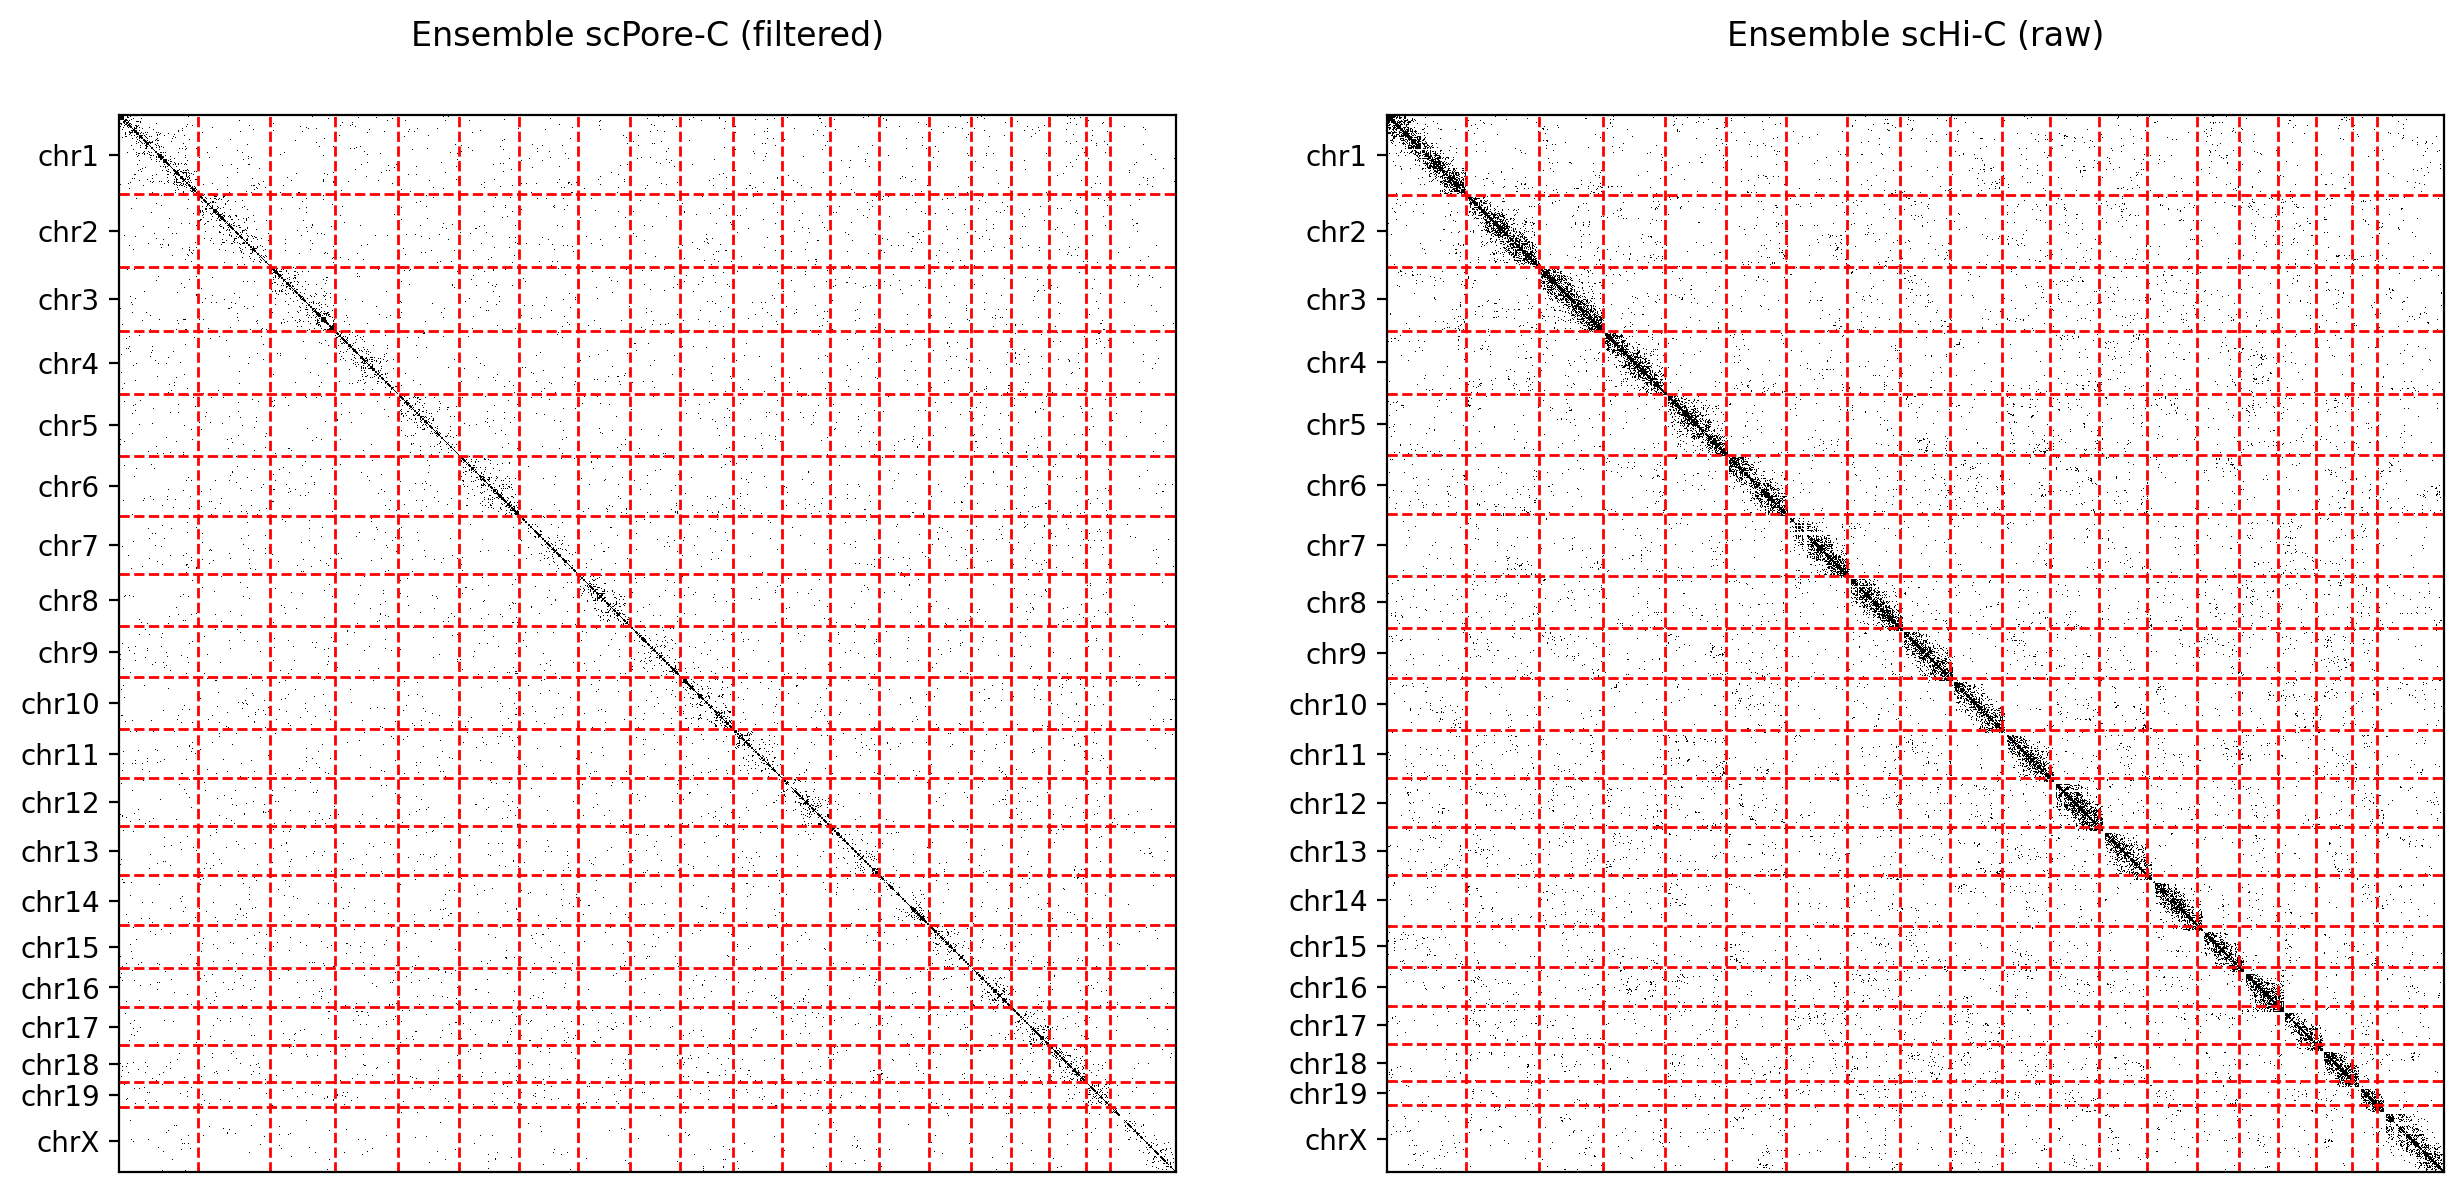

In [75]:
# individual cell summaries

bulkPoreCFiltered = np.zeros(A.shape)
for runId, A in matrices.items():
    bulkPoreCFiltered += A
    
bulkPFiltered = binarize(bulkPoreCFiltered)
    
print("filtered pore-c")
getStats(bulkPFiltered)
    
print("\nhi-c")
getStats(bulkH)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 15, 15
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.matshow(bulkPFiltered, cmap='binary')
ax1.set_title('Ensemble scPore-C (filtered)')

ax2.matshow(bulkH, cmap='binary')
ax2.set_title('Ensemble scHi-C (raw)')

ytick = []
ytickLabels = []

cnt = 0

ytick = []
ytickLabels = []

for chrm in chromOrder[:-1]:    
    row = filteredChromInfo.loc[filteredChromInfo['region'] == chrm]
    # remap to shuffled chrom position
    pos = row['length'].values[0] - 1
    cnt += pos

    ytick.append(cnt - pos // 2)
    ytickLabels.append(chrm)

    ax1.axhline(y=cnt, lw=1, ls='--',  c='r')    
    ax1.axvline(x=cnt, lw=1, ls='--',  c='r')    
        
ax1.set_yticks(ytick)
ax1.set_yticklabels(ytickLabels)
ax1.set_xticks([], [])

cnt = 0

ytick = []
ytickLabels = []

for chrm in chromOrder[:-1]:    
    row = hicChromInfo.loc[hicChromInfo['region'] == chrm]
    # remap to shuffled chrom position
    pos = row['length'].values[0] - 1
    cnt += pos

    ytick.append(cnt - pos / 2)
    ytickLabels.append(chrm)

    ax2.axhline(y=cnt, lw=1, ls='--',  c='r')    
    ax2.axvline(x=cnt, lw=1, ls='--',  c='r')    
        
ax2.set_yticks(ytick)
ax2.set_yticklabels(ytickLabels)
ax2.set_xticks([], [])

maxY = 2625
ax1.set_xlim(0, maxY)
ax1.set_ylim(maxY, 0)

maxY = 2630
ax2.set_xlim(0, maxY)
ax2.set_ylim(maxY, 0)

In [ ]:
break

In [ ]:
filteredPoreCIndex = list(range(0, len(bulkPFiltered)))
print(f"{len(filteredPoreCIndex)=}")

In [ ]:
chromosome = ['chr2']
chrHicInd = pcu.getIndices(hicChromInfo, hicIndex, chromosome, 'region')
chrPorecInd = pcu.getIndices(filteredChromInfo, filteredPoreCIndex, chromosome, 'region')

hicChr = bulkH[chrHicInd, :][:, chrHicInd]
porecChr = bulkPFiltered[chrPorecInd, :][:, chrPorecInd]

# get correlation matrices
hiCCorr = getCorrelationMatrix(hicChr)
porecCorr =  getCorrelationMatrix(porecChr)

print(f"{hicChr.shape=}")
print(f"{porecChr.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 15, 15


fig = plt.figure()

fig.add_subplot(221)
plt.imshow(porecChr, cmap='binary')
plt.title(f'Ensemble Pore-C (filtered, {chromosome})')

fig.add_subplot(222)
plt.imshow(hicChr, cmap='binary')
plt.title(f'Ensemble Hi-C (raw, {chromosome})')

# fig.add_subplot(223)
# plt.imshow(porecCorr, cmap='binary')
# plt.title(f'Ensemble Pore-C Correlation Matrix (filtered, {chromosome})')

# fig.add_subplot(224)
# plt.imshow(hiCCorr, cmap='binary')
# plt.title(f'Ensemble Hi-C Correlation Matrix (raw, {chromosome})')

In [ ]:
# # save a single .mat file

# outputdir = "data/"

# chromosome = ['chr2']

# assert(len(chromosome) == 1)

# for pKey in matrices.keys():
    
#     print(f"{pKey=}")
    
#     # get matrices and filter
#     pMat = matrices[pKey]
        
#     chrPorecInd = getIndices(filteredChromInfo, filteredPoreCIndex, chromosome, 'region')
    
#     A = pMat[:, chrPorecInd][chrPorecInd, :]
#     A = np.where(A > 0, 1, 0)
    
#     fileName = f"{outputdir}{pKey}{chromosome[0]}.mat"
    
#     scipy.io.savemat(fileName, {'A': A})
    
    
# print('done.')


In [ ]:
# pseduobulk 
chromosome = ['chr2', 'chr5', 'chr13']
chrHicInd = pcu.getIndices(hicChromInfo, hicIndex, chromosome, 'region')
chrPorecInd = pcu.getIndices(filteredChromInfo, filteredPoreCIndex, chromosome, 'region')

hicChr = bulkH[chrHicInd, :][:, chrHicInd]
porecChr = bulkPFiltered[chrPorecInd, :][:, chrPorecInd]

print(f"{hicChr.shape=}")
print(f"{porecChr.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 15, 15
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.matshow(porecChr, cmap='binary')
ax1.set_title(f'Pseudobulk Pore-C (filtered, {chromosome})')

cnt = 0
for chrm in chromosome[:-1]:    
    row = filteredChromInfo.loc[filteredChromInfo['region'] == chrm]
    # remap to shuffled chrom position
    
    pos = row['length'].values[0] - 1
    cnt += pos
    
    ax1.axhline(y=cnt, lw=1,  c='r')    
    ax1.axvline(x=cnt, lw=1,  c='r')  
    

ax2.matshow(hicChr, cmap='binary')
ax2.set_title(f'Pseudobulk Hi-C (raw, {chromosome})')


cnt = 0
for chrm in chromosome[:-1]:    
    row = hicChromInfo.loc[hicChromInfo['region'] == chrm]
    # remap to shuffled chrom position
    
    pos = row['length'].values[0] - 1
    cnt += pos
    
    ax2.axhline(y=cnt, lw=1,  c='r')    
    ax2.axvline(x=cnt, lw=1,  c='r')  


In [ ]:
chromosome = ['chr2']
chrHicInd = pcu.getIndices(hicChromInfo, hicIndex, chromosome, 'region')
chrPorecInd = pcu.getIndices(filteredChromInfo, filteredPoreCIndex, chromosome, 'region')

hMat = bulkH[chrHicInd, :][:, chrHicInd]
pMat = bulkPFiltered[chrPorecInd, :][:, chrPorecInd]

np.fill_diagonal(pMat, 1)
np.fill_diagonal(hMat, 1)

hMat = pcu.forceAdjacentConnections(hMat)
pMat = pcu.forceAdjacentConnections(pMat)

pC = getCorrelationMatrix(pMat)
hC = getCorrelationMatrix(hMat)

porecPC1 = getPC1(pC)
hicPC1 = getPC1(hC)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 4
fig = plt.figure()

fig.add_subplot(221)
plt.bar(range(len(porecPC1)), porecPC1, color='k')

fig.add_subplot(222)
plt.bar(range(len(hicPC1)), hicPC1, color='k')

fig.add_subplot(223)
plt.imshow(pC, cmap='binary')

fig.add_subplot(224)
plt.imshow(hC, cmap='binary')

In [ ]:
break

In [ ]:
# u, s, vh = np.linalg.svd(hC)

# plt.bar(range(len(s)), -u[:, 0])

In [ ]:
# break

# Individual Cell Comparisons

In [ ]:
chromosome = ['chr2']

zippedKeys = list(zip(matrices.keys(), hic.keys()))
for pKey, hKey in zippedKeys:
    
    print(f"{pKey=} {hKey=}")
    
    
    # get matrices and filter
    pMat = matrices[pKey]
    hMat = hic[hKey]
        
    chrPorecInd = pcu.getIndices(filteredChromInfo, filteredPoreCIndex, chromosome, 'region')
    chrHicInd = pcu.getIndices(hicChromInfo, hicIndex, chromosome, 'region')
    
    pMat = binarize(pMat[:, chrPorecInd][chrPorecInd, :])
    hMat = binarize(hMat[:, chrHicInd][chrHicInd, :])
    
    print(f"{pMat.shape=} {hMat.shape=}")
        
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 15, 15
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    ax1.matshow(pMat, cmap='binary')
    ax1.set_title(f'scPore-C - {pKey} (f{chromosome})')

    cnt = 0
    for chrm in chromosome[:-1]:    
        row = filteredChromInfo.loc[filteredChromInfo['region'] == chrm]
        # remap to shuffled chrom position

        pos = row['length'].values[0] - 1
        cnt += pos

        ax1.axhline(y=cnt, lw=2,  c='r')    
        ax1.axvline(x=cnt, lw=2,  c='r')  


    ax2.matshow(hMat, cmap='binary')
    ax2.set_title(f'scHi-C - {hKey} ({chromosome})')


    cnt = 0
    for chrm in chromosome[:-1]:    
        row = hicChromInfo.loc[hicChromInfo['region'] == chrm]
        # remap to shuffled chrom position

        pos = row['length'].values[0] - 1
        cnt += pos

        ax2.axhline(y=cnt, lw=2,  c='r')    
        ax2.axvline(x=cnt, lw=2,  c='r')  
    
    plt.show()
    
    break


In [ ]:
chromosome = ['chr2']

zippedKeys = list(zip(matrices.keys(), hic.keys()))

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 20, 10
fig = plt.figure()
    
count = 0
for pKey, hKey in zippedKeys:
    print("----------------")
    print(f"{pKey=} {hKey=}")
    
    # get matrices and filter
    pMat = matrices[pKey]
    hMat = hic[hKey]
        
    chrPorecInd = pcu.getIndices(filteredChromInfo, filteredPoreCIndex, chromosome, 'region')
    chrHicInd = pcu.getIndices(hicChromInfo, hicIndex, chromosome, 'region')
    
    pMat = binarize(pMat[:, chrPorecInd][chrPorecInd, :])
    hMat = binarize(hMat[:, chrHicInd][chrHicInd, :])
    
    print(f"{pMat.shape=} {hMat.shape=}")
    
    pRowSum = np.sum(pMat, axis=0)
    hRowSum = np.sum(hMat, axis=0)
    
    fig.add_subplot(len(matrices), 2, count+1)    
    plt.bar(range(len(pRowSum)), pRowSum)
    plt.title(f"{pKey}")
    
    fig.add_subplot(len(matrices), 2, count+2)    
    plt.bar(range(len(hRowSum)), hRowSum)
    plt.title(f"{hKey}")

    count += 2
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.5)

# trans Conparisons

In [ ]:
chromosome = ['chr2']
colIndex = pcu.getIndices(filteredChromInfo, filteredPoreCIndex, chromosome, 'region')


plt.rcParams['figure.figsize'] = 4, 13


fig = plt.figure()
figCount = 0
for runId, A in matrices.items():
    figCount += 1 
    
    transA = A[:, colIndex]
    
    transA = np.where(transA > 0, 1, 0)
    
    fig.add_subplot(1, len(matrices), figCount)
    
    plt.spy(transA, marker='s', c='b', markersize=0.5, alpha=0.4)
    
    cnt = 0
    
    ytick = []
    ytickLabels = []
    
    for chrm in chromOrder:    
        row = filteredChromInfo.loc[filteredChromInfo['region'] == chrm]
        # remap to shuffled chrom position

        pos = row['length'].values[0] - 1
        cnt += pos
        
        ytick.append(cnt - pos // 2)
        ytickLabels.append(chrm)

        plt.axhline(y=cnt, lw=0.5, ls='--',  c='k')    
        
    plt.xticks([], [])
    plt.title(f"{runId}", y=1.001)
    if figCount == 1:
        plt.yticks(ytick, ytickLabels)
    else:
        plt.yticks([], [])

plt.subplots_adjust(left=0.01,
                    bottom=0.1, 
                    right=0.99, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.01)    

# PC1 Comparisons

In [ ]:
chromosome = ['chr2']

zippedKeys = list(zip(matrices.keys(), hic.keys()))
for pKey, hKey in zippedKeys:
    
    print(f"\n{pKey=} {hKey=}")
    
    
    # get matrices and filter
    pMat = matrices[pKey]
    hMat = hic[hKey]
        
    chrPorecInd = pcu.getIndices(filteredChromInfo, filteredPoreCIndex, chromosome, 'region')
    chrHicInd = pcu.getIndices(hicChromInfo, hicIndex, chromosome, 'region')
    
    pMat = binarize(pMat[:, chrPorecInd][chrPorecInd, :])
    hMat = binarize(hMat[:, chrHicInd][chrHicInd, :])
    
    print(f"{pMat.shape=} {hMat.shape=}")
    
    # fill the diagonal
    np.fill_diagonal(pMat, 1)
    np.fill_diagonal(hMat, 1)
    
    # force adjacent connections
    hMat = pcu.forceAdjacentConnections(hMat)
    pMat = pcu.forceAdjacentConnections(pMat)
    
#     pMat = pageRankNormalize(pMat)
#     hMat = pageRankNormalize(hMat)
    
#     pC = getCorrelationMatrix(pMat)
#     hC = getCorrelationMatrix(hMat)

    pC = getJaccardMatrix(pMat)
    hC = getJaccardMatrix(hMat)

    
    print(f"{np.linalg.matrix_rank(pC)=} {np.linalg.matrix_rank(hC)=}")
    
    pPC1 = getPC1(pC)
    hPC1 = getPC1(hC)
    
    r = stats.pearsonr(pPC1, hPC1)
    
    correlation = r[0]
    pvalue = r[1]
    
    print(f"{correlation=:.4f}, {pvalue=:.4f}")
    
    
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 10, 10
    
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.025


    hicPlotSize = [left, bottom, width, height]
    pcPlotSize = [left, bottom + height + spacing, width, 0.1]

    # start with a square Figure
    fig = plt.figure()

    ax1 = fig.add_axes(hicPlotSize)
    
    c_white = matplotlib.colors.colorConverter.to_rgba('white', alpha = 0)
    c_black = matplotlib.colors.colorConverter.to_rgba('black', alpha = 1)
    
    c_C0 = matplotlib.colors.colorConverter.to_rgba('C0', alpha = 0.7)
    c_C1 = matplotlib.colors.colorConverter.to_rgba('C1', alpha = 0.7)

    cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list('cmap1',[c_white, c_black], 512)
    cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list('cmap2',[c_white, c_C0], 512)
    cmap3 = matplotlib.colors.LinearSegmentedColormap.from_list('cmap3',[c_white, c_C1], 512)
    
    
    T = hMat + pMat
    commmonContacts = np.where(T == 2, 1, 0)
    
    ax1.imshow(pMat, cmap=cmap2)
    ax1.imshow(hMat, cmap=cmap3)    
    ax1.imshow(commmonContacts, cmap=cmap1)
    
    
    legend_elements = [Patch(facecolor='k', edgecolor='k', label='Common Contacts'),
                       Patch(facecolor=c_C0, edgecolor='k', label=pKey),
                       Patch(facecolor=c_C1, edgecolor='k', label=hKey)]
    
    ax1.legend(handles=legend_elements)

    ax2 = fig.add_axes(pcPlotSize, sharex=ax1)
    
    ax2.bar(range(len(pPC1)), pPC1, alpha=0.8, label=pKey)    
    ax2.bar(range(len(hPC1)), hPC1, alpha=0.5, label=hKey)
    ax2.legend()
    
    ax2.set_title(f"Single-Cell Comparison({chromosome})")
    
    cnt = 0
    for chrm in chromosome[:-1]:    
        row = filteredChromInfo.loc[filteredChromInfo['region'] == chrm]
        # remap to shuffled chrom position

        pos = row['length'].values[0] - 1
        cnt += pos

        ax1.axhline(y=cnt, lw=1,ls="--", c='r')    
        ax1.axvline(x=cnt, lw=1,ls="--", c='r')  
        ax2.axvline(x=cnt, lw=1,ls="--", c='r')  
    
    plt.show()
    break

# Imputation 

In [ ]:
def imputeContacts(A, tau=0.5, alpha=0.1):
    """A functiont to impute contacts based on the existing
    structure """
    G = nx.from_numpy_array(A)    
    P = np.zeros(A.shape)
    
    pLink = nx.common_neighbor_centrality(G, alpha=alpha)
    for i, j, p in pLink:
        P[i, j] = P[i, j] + p
        P[j, i] = P[j, i] + p
    
    # normalize the link scores
    P = P / P.max()
    
    # threshold based prediction
    P = np.where(P >= tau, 1, 0)
    return P

In [ ]:
chromosome = ['chr2']

alpha = 0.5
tau = 0.6

zippedKeys = list(zip(matrices.keys(), hic.keys()))
for pKey, hKey in zippedKeys:
    
    print(f"\n{pKey=} {hKey=}")
    
    
    # get matrices and filter
    pMat = matrices[pKey]
    hMat = hic[hKey]
        
    chrPorecInd = pcu.getIndices(filteredChromInfo, filteredPoreCIndex, chromosome, 'region')
    chrHicInd = pcu.getIndices(hicChromInfo, hicIndex, chromosome, 'region')
    
    pMat = binarize(pMat[:, chrPorecInd][chrPorecInd, :])
    hMat = binarize(hMat[:, chrHicInd][chrHicInd, :])
    
    porecP = imputeContacts(pMat, tau, alpha)
    hicP = imputeContacts(hMat, tau, alpha)
    
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 15, 15
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    c_white = matplotlib.colors.colorConverter.to_rgba('white',alpha = 0)
    c_black= matplotlib.colors.colorConverter.to_rgba('black',alpha = 1)
    cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list('cmap1',[c_white,c_black],512)
    
    ax1.matshow(pMat, cmap=cmap1)
    ax1.set_title(f'scPore-C - {pKey} (f{chromosome})')
    
    c_white = matplotlib.colors.colorConverter.to_rgba('white',alpha = 0)
    c_blue = matplotlib.colors.colorConverter.to_rgba('blue',alpha = 0.5)
    cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list('cmap2',[c_white,c_blue],512)
    
    ax1.matshow(porecP, cmap=cmap2)
    
    cnt = 0
    for chrm in chromosome[:-1]:    
        row = filteredChromInfo.loc[filteredChromInfo['region'] == chrm]
        # remap to shuffled chrom position

        pos = row['length'].values[0] - 1
        cnt += pos

        ax1.axhline(y=cnt, lw=1,  c='r')    
        ax1.axvline(x=cnt, lw=1,  c='r')  


    c_white = matplotlib.colors.colorConverter.to_rgba('white',alpha = 0)
    c_black= matplotlib.colors.colorConverter.to_rgba('black',alpha = 1)
    cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list('cmap1',[c_white,c_black],512)
    
    ax2.matshow(hMat, cmap=cmap1)
    
    c_white = matplotlib.colors.colorConverter.to_rgba('white',alpha = 0)
    c_blue = matplotlib.colors.colorConverter.to_rgba('blue',alpha = 0.5)
    cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list('cmap2',[c_white,c_blue],512)
    
#     ax2.matshow(hicP, cmap=cmap2)
    
#     ax2.set_title(f'scHi-C - {hKey} ({chromosome})')


    cnt = 0
    for chrm in chromosome[:-1]:    
        row = hicChromInfo.loc[hicChromInfo['region'] == chrm]
        # remap to shuffled chrom position

        pos = row['length'].values[0] - 1
        cnt += pos

        ax2.axhline(y=cnt, lw=1,  c='r')    
        ax2.axvline(x=cnt, lw=1,  c='r')  
    
    plt.show()
    
    break


In [ ]:
# zippedKeys = list(zip(porec.keys(), hic.keys()))
        

# for pKey, hKey in zippedKeys:
    
#     print("------------------------")
#     print(f"{pKey=}")
#     print(f"{hKey=}")
#     pMat = porec[pKey].matrix(balance=True)[:]
#     hMat = hic[hKey].matrix(balance=True)[:]
    
    
#     # reindex the data
#     hMat = hMat[hicIndex, :][:, hicIndex]
#     pMat = pMat[porecIndex, :][:, porecIndex]
    
#     print(f"{hMat.shape=}")
#     print(f"{pMat.shape=}")
    
    
#      # binarize both
#     pMatBinary = np.where(pMat > 0, 1, 0)
#     hMatBinary = np.where(hMat > 0, 1, 0)
    
#     A = np.zeros(hMat.shape)
    
#     # truncate the y chrome of the porec data
#     n = hMat.shape[0]
#     pMatBinary = pMatBinary[0:n, 0:n]
    
#     # get upper and lower triangles
#     pMatTri = np.triu(pMatBinary)
#     hMatTri = np.tril(hMatBinary)
    
#     A += pMatTri
#     A += hMatTri
    
#     ABinary = np.where(A > 0, 1, 0)
    
#     plt.matshow(ABinary, cmap='binary')
#     plt.title(f'Raw scPore-C Contacts {pKey}', y=1.1)
#     plt.text((n//2), n+300, f"Raw scHi-C Contacts {hKey}", 
#              horizontalalignment='center', fontsize=12)
    
#     plt.show()

In [ ]:
break

In [ ]:
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 10, 10

# zippedKeys = list(zip(poreC.keys(), hiC.keys()))

# for pKey, hKey in zippedKeys:
    
#     print("------------------------")
#     print(f"{pKey=}")
#     print(f"{hKey=}")
#     pMat = poreC[pKey].matrix(balance=True)[:]
#     hMat = hiC[hKey].matrix(balance=True)[:]
    
#     # binarize both
#     pMatBinary = np.where(pMat > 0, 1, 0)
#     hMatBinary = np.where(hMat > 0, 1, 0)
    
#     sumPoreC = np.triu(pMatBinary).sum()
#     sumPoreCDiag = np.diag(pMatBinary).sum()
    
#     sumhiC = np.triu(hMatBinary).sum()
#     sumhiCDiag = np.diag(hMatBinary).sum()
    
#     print()
#     print(f"{sumPoreC=}")
#     print(f"{sumPoreCDiag=}")
#     print(f"{sumPoreCDiag/sumPoreC=:.3f}")
    
#     print()
#     print(f"{sumhiC=}")
#     print(f"{sumhiCDiag=}")
#     print(f"{sumhiCDiag/sumPoreC=:.3f}")
    

# #     fig, ax = plt.subplots(1, 2) 
    
# #     ax[0].matshow(pMatBinary, cmap='binary')
# #     ax[0].set_title(f'scPore-C Contacts: {pKey}', y=1.2)

# #     ax[1].matshow(hMatBinary, cmap='binary')
# #     ax[1].set_title(f'scHi-C Contacts: {hKey}', y=1.2)
    
# #     plt.show()
    

In [ ]:
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 10, 10

# zippedKeys = list(zip(poreC.keys(), hiC.keys()))

# for pKey, hKey in zippedKeys:
    
#     print("------------------------")
#     print(f"{pKey=}")
#     print(f"{hKey=}")
#     pMat = poreC[pKey].matrix(balance=True)[:]
#     hMat = hiC[hKey].matrix(balance=True)[:]
    
#     # binarize both
#     pMatBinary = np.where(pMat > 0, 1, 0)
#     hMatBinary = np.where(hMat > 0, 1, 0)
    
#     A = np.zeros(hMat.shape)
    
#     # truncate the y chrome of the porec data
#     n = hMat.shape[0]
#     pMatBinary = pMatBinary[0:n, 0:n]
    
#     # get upper and lower triangles
#     pMatTri = np.triu(pMatBinary)
#     hMatTri = np.tril(hMatBinary)
    
#     A += pMatTri
#     A += hMatTri
    
#     ABinary = np.where(A > 0, 1, 0)
    
#     plt.matshow(ABinary, cmap='binary')
#     plt.title(f'Raw scPore-C Contacts {pKey}')
#     plt.text((n//2), n+100, f"Raw scHi-C Contacts {hKey}", 
#              horizontalalignment='center', fontsize=12)
    
    
#     plt.show()

In [ ]:


# psuedoPoreC = np.zeros(poreC['run01'].shape)

# for k,v in poreC.items():
#     psuedoPoreC += v.matrix(balance=True)[:]
    

# # kinda hacky
# psuedoHiC = np.zeros(hiC[list(hiC.keys())[0]].shape)
    
# for k,v in hiC.items():
#     psuedoHiC += v.matrix(balance=True)[:]

# print(f"{psuedoPoreC.shape=}")
# print(f"{psuedoHiC.shape=}")


In [ ]:
# pMatBinary = np.where(psuedoPoreC > 0, 1, 0)
# hMatBinary = np.where(psuedoHiC > 0, 1, 0)

# A = np.zeros(psuedoHiC.shape)

# # truncate the y chrome of the porec data
# n = psuedoHiC.shape[0]
# pMatBinary = pMatBinary[0:n, 0:n]

# # get upper and lower triangles
# pMatTri = np.triu(pMatBinary)
# hMatTri = np.tril(hMatBinary)

# A += pMatTri
# A += hMatTri

# ABinary = np.where(A > 0, 1, 0)

# plt.matshow(ABinary, cmap='binary')
# plt.title(f'Raw scPore-C Contacts Ensemble')
# plt.text((n//2), n+100, f"Raw scHi-C Contacts Ensemble", 
#          horizontalalignment='center', fontsize=12)


In [ ]:
# plt.close()
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 3, 3

# # chromosome 2
# zippedKeys = list(zip(poreC.keys(), hiC.keys()))

# for pKey, hKey in zippedKeys:
    
#     print("------------------------")
#     print(f"{pKey=}")
#     print(f"{hKey=}")
#     pMat = poreC[pKey].matrix(balance=True).fetch('NC_000068.8')[:]
#     hMat = hiC[hKey].matrix(balance=True).fetch('chr2')[:]
    
#     print(f"{pMat.shape}")
#     print(f"{hMat.shape}")
    
    
#     # binarize both
#     pMatBinary = np.where(pMat > 0, 1, 0)
#     hMatBinary = np.where(hMat > 0, 1, 0)
    
#     # get upper and lower triangles
#     pMatTri = np.triu(pMatBinary)
#     hMatTri = np.tril(hMatBinary)
    
#     A = np.zeros(pMat.shape)
    
#     A += pMatTri
#     A += hMatTri
    
#     ABinary = np.where(A > 0, 1, 0)
    
#     plt.matshow(ABinary, cmap='binary')
#     plt.title(f'Raw scPore-C Contacts {pKey}')
#     plt.text((n//2), n+100, f"Raw scHi-C Contacts {hKey}", 
#              horizontalalignment='center', fontsize=12)
    
#     plt.show()
    
#     break

In [ ]:
# A = np.zeros(psuedoHiC.shape)

# # truncate the y chrome of the porec data
# n = psuedoHiC.shape[0]
# psuedoPoreC = psuedoPoreC[0:n, 0:n]

# # get upper and lower triangles
# pMatTri = np.triu(psuedoPoreC)
# hMatTri = np.tril(psuedoHiC)

# A += pMatTri
# A += hMatTri

# plt.matshow(A, cmap='Reds')
# plt.title(f'Raw scPore-C Contacts Ensemble')
# plt.text((n//2), n+100, f"Raw scHi-C Contacts Ensemble", 
#          horizontalalignment='center', fontsize=12)